In [1]:
import os
from decouple import config
from utils import *

In [76]:
from fastai2.vision.widgets import *

In [2]:
# from page 66 it is recomeneded that we get a bing api key and download some images from bing
# created my api key with ms bing, azure
# added it to my env vars
# lets see if its there

In [4]:
## STEP 1: Download some images
##  if images already downloaded, skip to STEP 2

# get the api key from the environ var
#key1=os.environ['bing_key_1']
#key1
# for whatever reason, this was failing.  so instead i am using python-decouple 
# with my keys store in the .env file.  gotta keep the "secrets" secret

API_KEY_1 = config('bing_key_1')

API_KEY_2 = config('bing_key_2')
API_END_POINT=config('bing_end_point')
API_KEY_1[0:4] + '|' + API_KEY_2[0:4] + '|' + API_END_POINT[0:10] # have a look at the first few characters of the key, to be sure its there


'4c38|b0b7|https://ph'

In [5]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [6]:
results = search_images_bing(API_KEY_1, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)
ims[0]

'http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg'

In [8]:
# lets download one
dest='images/grizzly.jpg'
download_url(ims[0], dest)

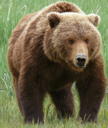

In [9]:
#lets have a peek at it
im = Image.open(dest)
im.to_thumb(128,128)

In [32]:
# lets do a better search with bing, for the 3 types of bears in question, and sve them locally
#if you want to run it twice, delete the bears folder

bear_types= ['grizzly' , 'panda', 'teddy']
path=Path('bears')
if not path.exists():
    path.mkdir()
    for bear_type in bear_types:
        dest = (path/bear_type)
        dest.mkdir(exist_ok=True)
        print(bear_type + ' bear')
        results = search_images_bing(API_KEY_1, bear_type + ' bear')
        download_images(dest, urls=results.attrgot('content_url'))
    print('done downloading!')
else:
    print('cannot download, files already exist')

grizzly bear


panda bear


teddy bear


done downloading!


In [44]:
# lets verify the images
fns = get_image_files(path)

In [45]:
fns

(#420) [Path('bears/grizzly/00000000.jpg'),Path('bears/grizzly/00000001.jpg'),Path('bears/grizzly/00000002.jpg'),Path('bears/grizzly/00000003.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000008.jpg'),Path('bears/grizzly/00000009.jpg'),Path('bears/grizzly/00000010.jpg')...]

In [46]:
try:
    del failed
except:
    print('nothing to delete')

# find the images that failed to download properly
failed=verify_images(fns)

In [47]:
failed

(#0) []

In [48]:
len(failed)

0

In [49]:
#remove all of the failerd images
failed.map(Path.unlink)

(#0) []

In [53]:
## STEP 2:
bears = DataBlock (
blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=Resize(128))

In [55]:
dls=bears.dataloaders(path)

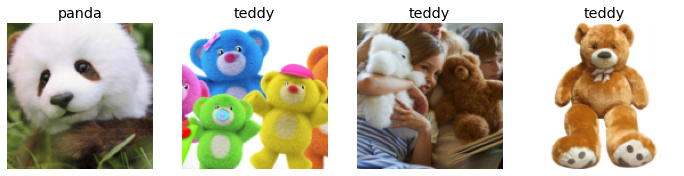

In [56]:
dls.valid.show_batch(max_n=4, nrows=1)

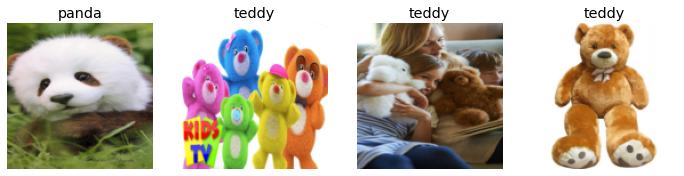

In [57]:
#by default, we could get some cropping when fastai tries to crop all to the same size
#letds squish, so as not to loose data
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

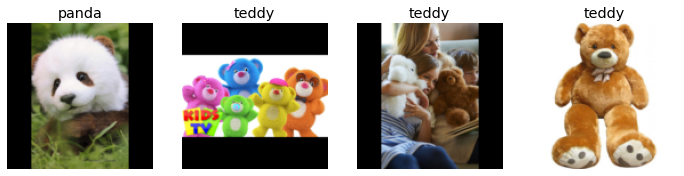

In [58]:
#lets try the same thing, this time we pad with zeros
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
 #but in real world, squishing warps what the bears really look like, do we really
# want a model trained to identify squished bears?
# and padding with zeros is wasteful, added image size more processing on nothing
# what we really want to do, is random crop on each pass through the data
# gives us a great way to train.  no squishine, no wasted space/processing and each image gets used a little bit differently
# on each pass, a data augmentation making each image worth more than 1 image


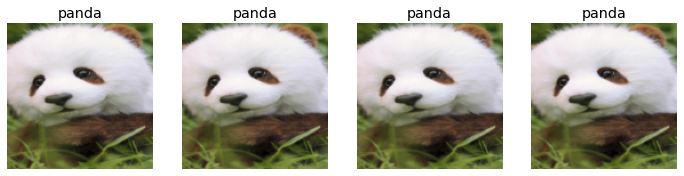

In [60]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

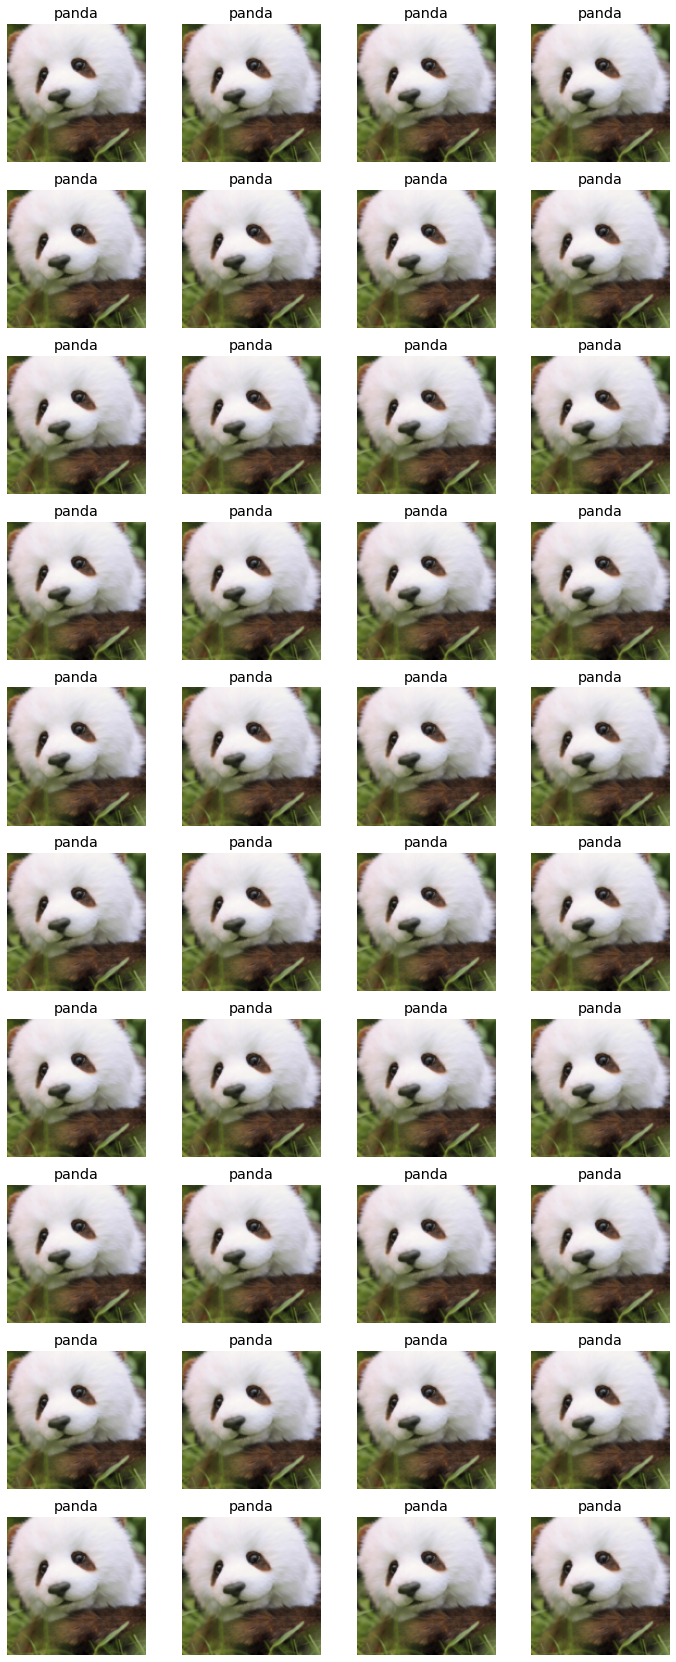

In [64]:
#we can now batch up the transforms and use the GPU
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=40, nrows=10, unique=True)

In [65]:
path

Path('bears')

In [94]:
#page 75 training
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                  batch_tfms=aug_transforms())
dls=bears.dataloaders(path)

In [95]:
learn=cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.153883,0.020469,0.000000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.115298,0.009018,0.000000,00:06
1,0.080907,0.005038,0.000000,00:06
2,0.061472,0.002456,0.000000,00:05
3,0.048598,0.001846,0.000000,00:05


In [96]:
interp = ClassificationInterpretation.from_learner(learn)

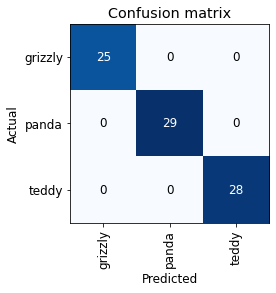

In [97]:
interp.plot_confusion_matrix()

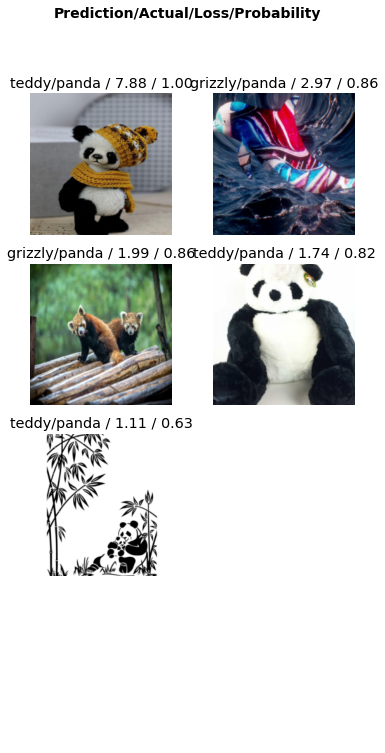

In [87]:
# to find the bad images, we can sort by loss
interp.plot_top_losses(5,nrows=4)

In [91]:
#fastai has a handy image cleaner gui
cleaner = ImageClassifierCleaner(learn)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/load.py", line 107, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/utils.py", line 299, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/load.py", line 120, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/load.py", line 126, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/core.py", line 293, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/core.py", line 293, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/core.py", line 270, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/data/core.py", line 232, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 203, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 155, in compose_tfms
    x = f(x, **kwargs)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 72, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 82, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/transform.py", line 88, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastcore/dispatch.py", line 99, in __call__
    return f(*args, **kwargs)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/vision/core.py", line 102, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai2/vision/core.py", line 77, in load_image
    im = Image.open(fn)
  File "/home/xbox/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py", line 2878, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/my-coding/fastai.100days/notebooks/bears/panda/00000129.jpg'


In [89]:
cleaner

In [90]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [98]:
## lets export the model
learn.export()

In [99]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [100]:
#for simple example, lets create a new model learner from the exported pkl
learn_inference=load_learner(Path()/'export.pkl')

In [101]:
learn_inference.predict('images/grizzly.jpg')

('grizzly', tensor(0), tensor([1.0000e+00, 6.0980e-07, 1.4614e-06]))

In [102]:
learn_inference.dls.vocab

(#3) ['grizzly','panda','teddy']

In [103]:
learn_inference.dls.vocab[0]

'grizzly'